## Policy measures analysis
In this notebook multiple policies can be tested, based on a chosen problem formulations. The effects on deaths and costs are summerized at the end of the notebook.

### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.2
2.8.2


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [4]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [5]:
used_problem_formulation = 2

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [6]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [7]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [8]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'), function=<function sum_over at 0x000001D5417BE5E0>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

### Policy formulations
In the following cells the wanted policies can be adjusted

In [9]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [10]:
pol_list = []
pol_list.append(create_policy({}, name="Zero"))

for meter in [0, 10]:
    for location in [0, 1, 2, 3, 4]:
        for ews_days in [2, 4]:
            pol_list.append(create_policy({"A.3_DikeIncrease 0": meter, f"{location}_RfR 0": 1, "EWS_DaysToThreat": ews_days},
                                          name=f"Dike_{meter}m_RfR_{location}_EWS_{ews_days}d"))


### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [11]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = False

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 5
    with MultiprocessingEvaluator(dike_model, n_processes=7) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 5 scenarios * 21 policies * 1 model(s) = 105 experiments
  1%|▍                                         | 1/105 [00:06<11:25,  6.59s/it]Traceback (most recent call last):
  File "C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 244, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\em_framework\ema_multiprocessing.py", line 253, in run
    self.callback(*result.get())
  File "C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 279, in __call__
    self._store_outcomes(experiment.experiment_id, outcomes)
  File "C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 258, in _s

### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [12]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs,Cost plus Damage,policy
0,7.062513e+08,0,NaN,NaN,NaN,0.000000e+00,7.062513e+08,Policy_Zero
1,1.961475e+09,0,0.0,0.000000,3.083685,0.000000e+00,1.961475e+09,Policy_Zero
2,1.284603e+09,0,0.0,0.000000,2.152642,0.000000e+00,1.284603e+09,Policy_Zero
3,1.784681e+09,0,0.0,0.000000,1.633709,0.000000e+00,1.784681e+09,Policy_Zero
4,3.002154e+09,0,0.0,0.000000,1.601619,0.000000e+00,3.002154e+09,Policy_Zero
...,...,...,...,...,...,...,...,...
100,7.062513e+08,44215020,256100000.0,51502.549058,0.085185,3.003665e+08,1.006618e+09,Policy_Dike_10m_RfR_4_EWS_4d
101,1.150770e+09,44215020,256100000.0,90928.125591,0.111334,3.004059e+08,1.451176e+09,Policy_Dike_10m_RfR_4_EWS_4d
102,8.897779e+07,44215020,256100000.0,4559.218838,0.008884,3.003196e+08,3.892974e+08,Policy_Dike_10m_RfR_4_EWS_4d
103,1.784681e+09,44215020,256100000.0,31641.698117,0.196045,3.003467e+08,2.085027e+09,Policy_Dike_10m_RfR_4_EWS_4d


In [13]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [14]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "Expected Number of Deaths": agg_par,
    "Expected Annual Damage": agg_par,
    "Total Costs": "mean",
    "Cost plus Damage": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

Expected Number of Deaths                      \
                                                  mean       min       max   
policy                                                                       
Policy_Dike_0m_RfR_0_EWS_2d                   0.242213  0.097286  0.462553   
Policy_Dike_0m_RfR_0_EWS_4d                   0.193770  0.077829  0.370042   
Policy_Dike_0m_RfR_1_EWS_2d                   0.242632  0.097286  0.462553   
Policy_Dike_0m_RfR_1_EWS_4d                   0.194106  0.077829  0.370042   
Policy_Dike_0m_RfR_2_EWS_2d                   0.221487  0.082669  0.427563   
Policy_Dike_0m_RfR_2_EWS_4d                   0.177190  0.066135  0.342050   
Policy_Dike_0m_RfR_3_EWS_2d                   0.252049  0.085139  0.444998   
Policy_Dike_0m_RfR_3_EWS_4d                   0.201639  0.068111  0.355999   
Policy_Dike_0m_RfR_4_EWS_2d                   0.273830  0.106482  0.457500   
Policy_Dike_0m_RfR_4_EWS_4d                   0.219064  0.085185  0.366000   
Policy_Dike_10m_RfR_0_EWS_2d                  0.096777  0.010777  0.207936   
Policy_Dike_10m_RfR_0_EWS_4d                  0.077422  0.008621  0.166348   
Policy_Dike_10m_RfR_1_EWS_2d                  0.096218  0.010777  0.208052   
Policy_Dike_10m_RfR_1_EWS_4d                  0.076974  0.008621  0.166442   
Policy_Dike_10m_RfR_2_EWS_2d                  0.143425  0.012491  0.245056   
Policy_Dike_10m_RfR_2_EWS_4d                  0.114740  0.009993  0.196045   
Policy_Dike_10m_RfR_3_EWS_2d                  0.134326  0.011033  0.245056   
Policy_Dike_10m_RfR_3_EWS_4d                  0.107461  0.008826  0.196045   
Policy_Dike_10m_RfR_4_EWS_2d                  0.148411  0.011105  0.245056   
Policy_Dike_10m_RfR_4_EWS_4d                  0.118729  0.008884  0.196045   
Policy_Zero                                   2.117914  1.601619  3.083685   

                                                 Expected Annual Damage  \
                                   q05       q95                   mean   
policy                                                                    
Policy_Dike_0m_RfR_0_EWS_2d   0.102570  0.433958           1.381455e+09   
Policy_Dike_0m_RfR_0_EWS_4d   0.082056  0.347167           1.381455e+09   
Policy_Dike_0m_RfR_1_EWS_2d   0.102967  0.433958           1.386287e+09   
Policy_Dike_0m_RfR_1_EWS_4d   0.082373  0.347167           1.386287e+09   
Policy_Dike_0m_RfR_2_EWS_2d   0.088516  0.391061           1.579126e+09   
Policy_Dike_0m_RfR_2_EWS_4d   0.070813  0.312849           1.579126e+09   
Policy_Dike_0m_RfR_3_EWS_2d   0.116160  0.405010           1.650255e+09   
Policy_Dike_0m_RfR_3_EWS_4d   0.092928  0.324008           1.650255e+09   
Policy_Dike_0m_RfR_4_EWS_2d   0.133234  0.429973           1.743378e+09   
Policy_Dike_0m_RfR_4_EWS_4d   0.106587  0.343979           1.743378e+09   
Policy_Dike_10m_RfR_0_EWS_2d  0.015015  0.193533           9.466453e+08   
Policy_Dike_10m_RfR_0_EWS_4d  0.012012  0.154826           9.466453e+08   
Policy_Dike_10m_RfR_1_EWS_2d  0.014432  0.193626           9.455448e+08   
Policy_Dike_10m_RfR_1_EWS_4d  0.011546  0.154901           9.455448e+08   
Policy_Dike_10m_RfR_2_EWS_2d  0.026527  0.244094           1.320757e+09   
Policy_Dike_10m_RfR_2_EWS_4d  0.021221  0.195275           1.320757e+09   
Policy_Dike_10m_RfR_3_EWS_2d  0.025854  0.244094           1.242061e+09   
Policy_Dike_10m_RfR_3_EWS_4d  0.020683  0.195275           1.242061e+09   
Policy_Dike_10m_RfR_4_EWS_2d  0.030180  0.244094           1.346567e+09   
Policy_Dike_10m_RfR_4_EWS_4d  0.024144  0.195275           1.346567e+09   
Policy_Zero                   1.606432  2.944028           1.747833e+09   

                                                                        \
                                       min           max           q05   
policy                                                                   
Policy_Dike_0m_RfR_0_EWS_2d   3.795926e+08  2.679166e+09  4.302704e+08   
Policy_Dike_0m_RfR_0_EWS_4d   3.795926e+08  2.679166e+09  4

### Plots

TODO: Make make some nice Seaborn plots?

<AxesSubplot:xlabel='policy'>

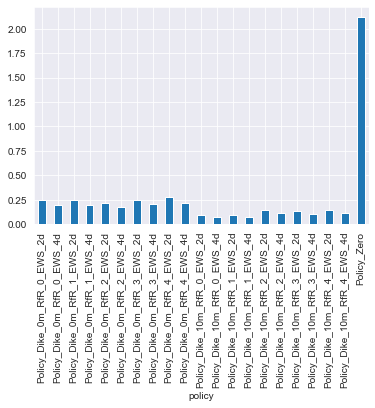

In [15]:
TCA_df["Expected Number of Deaths"]["mean"].plot.bar()

<AxesSubplot:xlabel='policy'>

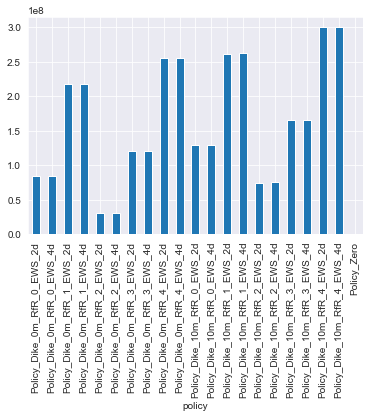

In [16]:
TCA_df["Total Costs"]["mean"].plot.bar()

<AxesSubplot:xlabel='policy'>

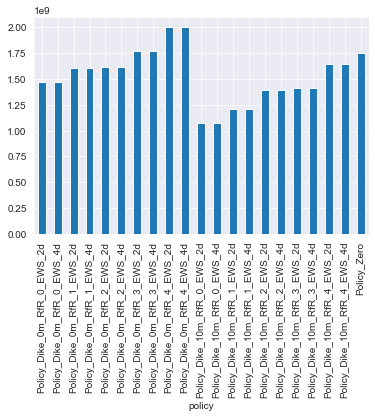

In [17]:
TCA_df["Cost plus Damage"]["mean"].plot.bar()

In [18]:
# Save the aggegrated data to a CSV file
TCA_df.to_csv(f"results/TCA_results_pf{used_problem_formulation}.csv")